# Case Study 3 - Spam vs. Ham

<hr>

# Import Packages

In [1]:
import os
from bs4 import BeautifulSoup
from email import message_from_string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from email.message import Message
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define functions for extraction/loading

## Extracting Content From Email

In [2]:
def extract_content_from_email(email_str):
    '''Extract the header & content from an email given as a string'''
    
    msg = message_from_string(email_str)

    # extract headers
    headers = dict(msg._headers)

    # If the email is multi-part
    if msg.is_multipart():
        content = []
        for part in msg.walk():
            content_type = part.get_content_type()
            payload = part.get_payload(decode=True)

            if payload is None:
                continue  # Skip and move on

            try:
                text = payload.decode('utf-8')
            except UnicodeDecodeError:
                try:
                    text = payload.decode('ascii')
                except:
                    text = payload.decode('ISO-8859-1')
            
            # Extract text from HTML
            if 'text/html' in content_type.lower():
                text = BeautifulSoup(text, 'lxml').get_text()

            content.append(text)
        content = ' '.join(content)
    else:
        content_type = headers.get('Content-Type', '')
        payload = msg.get_payload(decode=True)

        if payload is None:
            content = ""  # Empty string if the payload is None
        else:
            try:
                content = payload.decode('utf-8')
            except UnicodeDecodeError:
                try:
                    content = payload.decode('ascii')
                except:
                    content = payload.decode('ISO-8859-1')
            if 'text/html' in content_type.lower():
                content = BeautifulSoup(content, 'lxml').get_text()

    return headers, content


## Loading emails from local folders

In [3]:
def load_emails_from_folder(folder_path, label):
    '''load and preprocess emails from folder'''
    emails = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        
        try:
            # Try reading with UTF-8 encoding first
            with open(filepath, 'r', encoding='utf-8') as f:
                email_str = f.read()
        except UnicodeDecodeError:
            try:
                # If UnicodeDecodeError, try reading with ASCII
                with open(filepath, 'r', encoding='ascii') as f:
                    email_str = f.read()
            except UnicodeDecodeError:
                # If still a UnicodeDecodeError, try ISO-8859-1
                with open(filepath, 'r', encoding='ISO-8859-1') as f:
                    email_str = f.read()
        
        headers, content = extract_content_from_email(email_str)
        emails.append({
            'headers': headers,
            'content': content,
            'label': label
        })
    return emails

def load_all_emails():
    spam_folders = ['spam', 'spam_2']
    ham_folders = ['easy_ham', 'easy_ham_2', 'hard_ham']

    spam_emails = []
    ham_emails = []

    # Load spam emails from all folders
    for folder in spam_folders:
        spam_emails.extend(load_emails_from_folder(folder, 1))

    # Load ham emails from all folders
    for folder in ham_folders:
        ham_emails.extend(load_emails_from_folder(folder, 0))

    return spam_emails, ham_emails

spam_emails, ham_emails = load_all_emails()


<h3>*spam_emails* and *ham_emails* now are two lists which contain all the emails from the folder provided.<h3>

**Preprocessing the text is an important step so that we can train and identify characteristics that can be seen as "spam" or "ham"**

In [4]:
all_emails = spam_emails + ham_emails

In [5]:
for i, email in enumerate(all_emails):
    count = i
    if not isinstance(email.get('content'), str):
        print(f"Index {i}, place {count} has non-string content: {email.get('content')}")


In [6]:
all_emails[23]

{'headers': {'Return-Path': '<bell1hmed@yahoo.ca>',
  'Delivered-To': 'zzzz@localhost.spamassassin.taint.org',
  'Received': 'from n2now709.com ([64.86.155.148]) by dogma.slashnull.org\n    (8.11.6/8.11.6) with SMTP id g7MKV5Z23408 for <zzzz@jmason.org>;\n    Thu, 22 Aug 2002 21:31:06 +0100',
  'Message-Id': '<200208222031.g7MKV5Z23408@dogma.slashnull.org>',
  'From': '"Dr Bello Ahmed" <bell1hmed@yahoo.ca>',
  'Reply-To': 'bell1hmed@yahoo.ca',
  'Date': 'Thu, 22 Aug 2002 13:31:18 -0700',
  'Subject': 'Relationship',
  'X-Mailer': 'Microsoft Outlook Express 5.00.2919.6900 DM',
  'MIME-Version': '1.0',
  'Content-Type': 'multipart/mixed; boundary="===_SecAtt_000_1fheucnqggtggp"',
  'To': 'undisclosed-recipients:;'},
 'content': 'URGENT PRIVATE & EXTREMELY CONFIDENTIAL\n\n\n\nDear ,\n\nWith profound interest and in utmost confidence, I am\nsoliciting your immediate assistance or co-operation\nas to enable us round up an opportunity within my\ncapability as a result of the death of one of 

In [7]:
# 1. Text Cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers, special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


In [8]:
all_emails_cleaned = [clean_text(email['content']) for email in all_emails]
labels = [email['label'] for email in all_emails]

feature extraction 'BoW'

In [9]:
vectorizer = CountVectorizer()

vectorizer.fit(all_emails_cleaned)

CountVectorizer()

**The line below prints out the indicies of the words (not counts)**
- the text (for this example) is now essentially one hot encoded


In [10]:
vectorizer.vocabulary_

{'save': 66941,
 'life': 46041,
 'insurance': 40920,
 'spend': 71172,
 'quote': 62537,
 'savings': 66958,
 'ensuring': 27218,
 'familys': 29420,
 'financial': 31360,
 'security': 67664,
 'important': 39917,
 'makes': 48254,
 'buying': 11443,
 'simple': 69064,
 'affordable': 2546,
 'provide': 61101,
 'free': 32678,
 'access': 946,
 'best': 8185,
 'companies': 16369,
 'lowest': 47127,
 'rates': 63017,
 'fast': 29527,
 'easy': 24680,
 'saves': 66950,
 'money': 50891,
 'let': 45726,
 'us': 78662,
 'help': 36892,
 'get': 34168,
 'started': 71750,
 'values': 79353,
 'country': 17663,
 'new': 53104,
 'coverage': 17735,
 'hundreds': 38619,
 'even': 28118,
 'thousands': 75063,
 'dollars': 23246,
 'requesting': 64614,
 'lifequote': 46064,
 'service': 68160,
 'take': 73784,
 'less': 45697,
 'minutes': 50264,
 'complete': 16486,
 'shop': 68672,
 'compare': 16400,
 'types': 77185,
 'click': 15367,
 'protecting': 61050,
 'family': 29415,
 'investment': 41386,
 'youll': 84635,
 'ever': 28140,
 'make'

In [11]:
sample = vectorizer.transform([all_emails_cleaned[0]]).toarray()

In [12]:
sample.shape

(1, 85850)

In [13]:
sample

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
# number of occurances for the word 'save' based on the column information found above
sample[0][36679]

0

<hr>

# new

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tf_vectors = TfidfVectorizer()
new_vectors = tf_vectors.fit_transform(all_emails_cleaned)

In [17]:
new_vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
new_vectors.shape

(9353, 85850)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5) # to start with we will just use 5 

In [20]:
knn.fit(new_vectors, labels)

KNeighborsClassifier()

In [21]:
predictions = knn.predict(new_vectors)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, predictions)

0.569870629744467

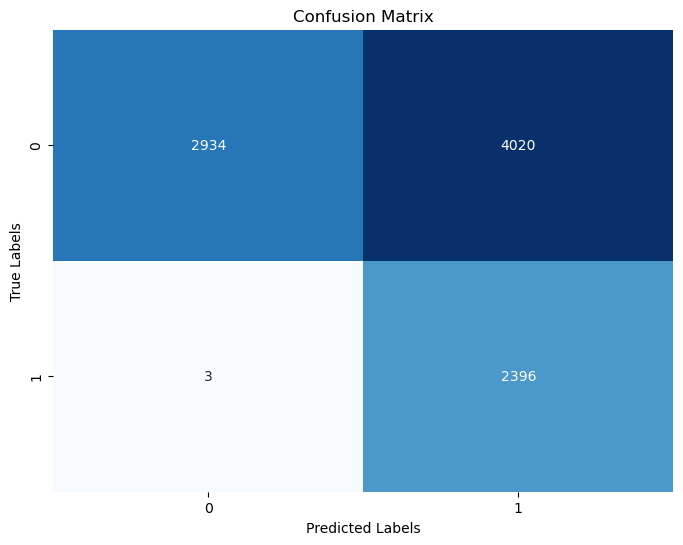

In [23]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(labels, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [24]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(new_vectors,labels)

KNeighborsClassifier(n_neighbors=10)

In [25]:
predictions = knn.predict(new_vectors)

In [26]:
accuracy_score(labels, predictions)

0.38779001389928364

In [27]:
from sklearn.cluster import DBSCAN

In [28]:
db = DBSCAN(eps = .5, min_samples = 5)

In [29]:
preds = db.fit_predict(new_vectors)

In [30]:
max(preds)

110

In [31]:
import pandas as pd
x = pd.DataFrame(preds)
x[0].value_counts()

-1      8402
 16       24
 24       22
 9        22
 8        21
        ... 
 69        5
 71        5
 73        5
 76        5
 110       5
Name: 0, Length: 112, dtype: int64

In [32]:
db = DBSCAN(eps=1.1, min_samples=5)
preds = db.fit_predict(new_vectors)
max(preds)
x = pd.DataFrame(preds)
x[0].value_counts()

0    9353
Name: 0, dtype: int64

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, tol = .0001, max_iter=300)

In [34]:
preds = kmeans.fit_predict(new_vectors)

c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
preds

array([0, 0, 0, ..., 0, 0, 1])

In [36]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


**Naive bayes**

In [37]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(new_vectors, labels)

MultinomialNB()

In [38]:
predictions = naive_bayes.predict(new_vectors)

In [39]:
accuracy = accuracy_score(labels, predictions)
print('accuracy',accuracy)

accuracy 0.9515663423500481


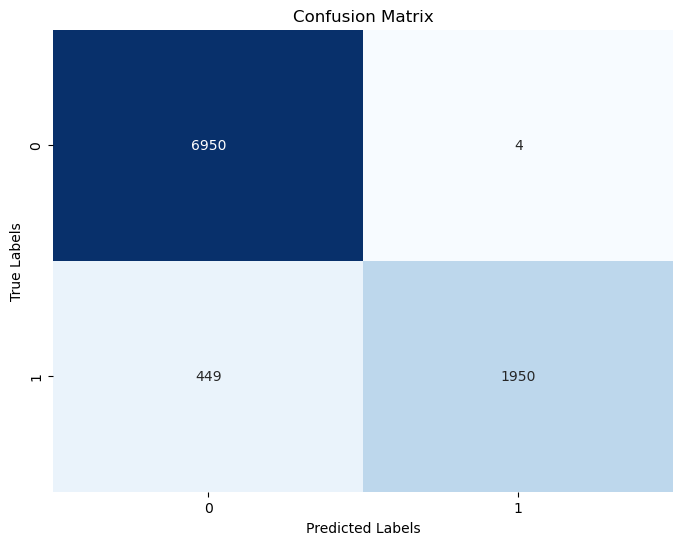

In [41]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(labels, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# new

<hr>

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_emails_cleaned)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = .2, random_state=12, shuffle=True)
train = (X_train, y_train)
test = (X_test, y_test)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the number of clusters
k=4

# Initialize and fit KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(train[0])

preds= kmeans.predict(test[0])



# Evaluate clustering if ground truth is known
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test[1], preds))
print(classification_report(test[1], preds))

c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1420    0]
 [ 451    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1420
           1       0.00      0.00      0.00       451

    accuracy                           0.76      1871
   macro avg       0.38      0.50      0.43      1871
weighted avg       0.58      0.76      0.65      1871



c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Possible hyperparameters to tune
eps_values = [20, 30, 40, 50, 60, 70, 80, 90]  # example range, adjust as needed
min_samples_values = [5, 7, 8, 9, 10,11,12,13,14,15]

best_eps = None
best_min_samples = None
best_silhouette = -1  # initialize with worst silhouette score

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        preds = dbscan.fit_predict(X_train)
        
        # Compute silhouette score only for valid clustering results (more than 1 cluster & less than n_samples clusters)
        n_clusters = len(set(preds)) - (1 if -1 in preds else 0)
        
        if 1 < n_clusters < X_train.shape[0]:
            silhouette_avg = silhouette_score(X_train, preds)
            if silhouette_avg > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = silhouette_avg

# Use the best hyperparameters to cluster the data
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
preds = dbscan.fit_predict(X_train)

# Evaluate clustering with best hyperparameters
print(f"Best eps={best_eps}, best min_samples={best_min_samples}")
print(confusion_matrix(y_train, preds))
print(classification_report(y_train, preds))



Best eps=90, best min_samples=10
[[   0    0    0]
 [  49 5485    0]
 [  27 1909   12]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.74      0.99      0.85      5534
           1       1.00      0.01      0.01      1948

    accuracy                           0.73      7482
   macro avg       0.58      0.33      0.29      7482
weighted avg       0.81      0.73      0.63      7482



c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
